# Metric Learning - LMNN

In [1]:
import sklearn.metrics as sk_metrics
import sklearn.decomposition as sk_decomp
import knnClassifier
import numpy as np
import Model
import Plots

# We ignore divisions by 0. We will do that in the chi square distance, but we don't care. 
np.seterr(divide='ignore', invalid='ignore')

Using TensorFlow backend.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Underneath you can define the hyperparameters, l, mu and K.
* $l$ is the margin parameter
* $\mu$ is a trade-off parameter between the push and pull in the loss function
* $K$ is the number of target neighbors 
* $D$ is the dimensionality of our data. We choose that arbitrarily
* $L$ is the linear transformation

L is set to be a diagonal matrix of ones to begin with. However, it would be interesting to experiement with other initial L matrices, since the problem is non-convex. We could also try to implement the constrained non-convex version of LMNN.

In [2]:
l = 0.3
mu = 1.2
K = 4
D = 40
L = np.eye(D)
alpha = 0.01

## Data Import & Analysis

In [3]:
high_dim_embeddings, labels = Model.get_data()
s_score = sk_metrics.silhouette_score(high_dim_embeddings.T, labels, metric='euclidean')

print("Shape of embeddings is: {}".format(np.shape(high_dim_embeddings)))
print("Shape of labels is: {} ".format(np.shape(labels)))
print("Silhouette Score of data is: {}".format(s_score))

Shape of embeddings is: (2048, 100)
Shape of labels is: (100,) 
Silhouette Score of data is: 0.6774616837501526


Next we need to do some dimensionality reduction. It turns out that having 2048 dimensions in the feature vector is not a good idea. Who could have predicted that? Therefore we visit our friend PCA. 

By runnning the next block, you reduce the dimensions corresponding to the F variable defined earlier. 

In [4]:
pca = sk_decomp.PCA(n_components=D)
pca.fit(high_dim_embeddings.T)
embeddings = pca.transform(high_dim_embeddings.T)
embeddings = abs(embeddings / np.linalg.norm(embeddings))
s_score = sk_metrics.silhouette_score(embeddings, labels, metric='euclidean')

print("Explained variance of low dimensional data is: {}".format(sum(pca.explained_variance_ratio_)))
print("Shape of embeddings is: {}".format(np.shape(embeddings)))
print("Shape of labels is: {} ".format(np.shape(labels)))
print("Silhouette Score of data is: {}".format(s_score))

Explained variance of low dimensional data is: 0.987623350287322
Shape of embeddings is: (100, 40)
Shape of labels is: (100,) 
Silhouette Score of data is: 0.6607000231742859


## Plots


Here we can plot the histogramified version of three images

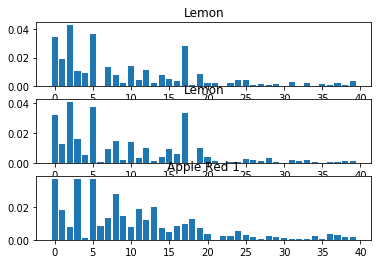

In [5]:
plot_items = embeddings[20:32:4,:]
plot_labels = labels[20:32:4]
Plots.plot_some_data(plot_items, plot_labels)

Next we plot the L matrix. At initilization we expect to see the diagonal matrix, but as we update L, we hope to see something different. 

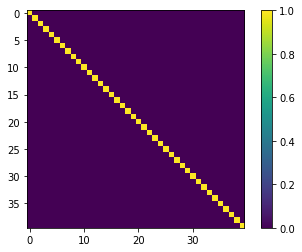

In [6]:
Plots.plot_kernel(L)

## Functions

Chi square distance, as described in equation (3) in the non-linear metric learning paper

In [7]:
def chi_square_distance(xi, xj):
    """
    Chi square distance

    :param xi: Embedding       (1, D)
    :param xj: Target Neighbor (1, D)
    :return: Distance
    """
    return 1/2 * np.nansum(np.square(xi - xj) / (xi + xj))

In [8]:
def gradient_chi(L, xi, xj):
    """
    Gradient of the Chi Square Distance
    
    :param L: Transformation Matrix (D, D)
    :param xi: Data vector i (1, D) 
    :param xj: Data Vector j (1, D) 
    :return: Gradient (D, D)
    """
    D = np.shape(L)[1]
    grad = np.zeros((D, D))
    
    xbari = L @ xi
    xbarj = L @ xj
    for p in range(D):
        t = (xbari[p] - xbarj[p]) / (xbari[p] + xbarj[p])
        for q in range(D):
            grad[p,q] = t*(xi[q]-xj[q])-0.5*(t**2)*(xi[q]+xj[q])
    return grad

Loss function as described in equaltion (5) in the paper

In [9]:
def loss_function(xi, xj, xk):
    """
    Loss function as described in the paper

    :param xi: One embedding        (D, 1)
    :param xj: K target neighbors   (D, K)
    :param xk: Unknown imposters    (D, ?)

    :return: Loss for one embedding
    """

    _, K = np.shape(xj)
    _, imposter = np.shape(xk)
    sum = 0

    for j in range(K):
        sum += chi_square_distance(L @ xi, L @ xj[:, j])
        inner_sum = 0
        for k in range(imposter):
            inner_sum += max(0, l + chi_square_distance(xi, xj[:, j]) - chi_square_distance(xi, xk[:, k]))
        sum += mu * inner_sum
    return sum


In [10]:
def gradient_loss(L, X, Y):
    """
    Loss function as described in the paper

    :param L: Transformation Matrid (D, D)
    :param X: Data Matrix (N, D)
    :param Y: Labels (1, N)

    :return: Gradient Loss (D, D) and loss
    """
    
    N, D = np.shape(X)
    Gradient_sum = np.zeros((D, D))
    Loss = 0
    for i in range(N):
        xj, xk = find_triplets(X[i], Y[i], X, Y)
        K, _ = np.shape(xj)
        imposter, _ = np.shape(xk)
        
        for j in range(K):
            Gradient_sum += gradient_chi(L, L @ X[i], L @ xj[j, :])
            Loss += chi_square_distance(L @ X[i], L @ xj[j, :])
            inner_sum = np.zeros((D, D))
            inner_loss = 0
            for k in range(imposter):
                if(l + chi_square_distance(L @ X[i], L @ xj[j,:]) - chi_square_distance(L @ X[i], L @ xk[k,:]) > 0):
                    inner_sum += gradient_chi(L, L @ X[i], L @ xj[j, :]) - gradient_chi(L, L @ X[i], L @ xk[k,:])
                    inner_loss += max(0, l + chi_square_distance(L @ X[i], L @ xj[j, :]) - chi_square_distance(L @ X[i], L @ xk[k,:]))
                Gradient_sum += mu * inner_sum
                Loss += mu * inner_loss
    return Gradient_sum, Loss

Functions to find triples. Distance function need to be changed, to find the distance through the L plane, and not just in the euclidean space. 

In [11]:
def distance(xi, X):
    """
    :param xi: Embedding vector                        (1, F)
    :param X: Data matrix without embedding vector (N - 1, F)
    :return: Distance vector                       (1, N - 1)
    """
    N, D = np.shape(X)
    Distances = np.zeros(N)
    for i in range(N):
        Distances[i] = chi_square_distance(L @ xi, L @ X[i, :])
    return Distances


def find_triplets(xi, yi, X, y):
    """
    Given some vector xi and corresponding label yi, find target neighbors and imposters

    :param xi: Embedding vector                                  (1, D)
    :param yi: Label for embedding vector
    :param X: Data matrix without embedding vector           (N - 1, D)
    :return: target_neighbors and imposters for embedding (K, D) (?, D)
    """
    candidate_target_neighbors = X[np.where(yi == y)]
    imposters = X[np.where(yi != y)]
    
    target_neighbors_dist = distance(xi, candidate_target_neighbors)
    imposters_dist = distance(xi, imposters)
    
    
    # Find K target neighbors
    target_neighbors = np.zeros((1, D))
    chosen_distances = np.zeros(K)
    for i in range(K):
        min_index = np.argmin(target_neighbors_dist)
        target_neighbors = np.vstack((target_neighbors, candidate_target_neighbors[min_index]))
        chosen_distances[i] = target_neighbors_dist[min_index]
        target_neighbors_dist = np.delete(target_neighbors_dist, (min_index), axis=0)
    target_neighbors = target_neighbors[1:, :]

    # Find ? imposters
    max_target_dist = np.max(chosen_distances)
    #print(max_target_dist)
    imposters = imposters[np.where(imposters_dist < max_target_dist + l)]
    #print("N_ Imposters{}".format(np.shape(imposters)))
    return target_neighbors, imposters

Next we define the update step for L given some gradient. <br/>

Additinally, it might be worth considering updating alpha. In one of the papers they state that "*(...) at each iteration, we increased α by a factor of 1.01 if the loss function decreased and decreased α by a factor of 0.5 if the loss function increased.*"


In [12]:
def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    
    # Map new L into correct space 
    new_L = np.abs(L - alpha * G)
    new_L = new_L / np.sum(new_L, axis=0)    
    
    #Update L
    L = new_L

## Run LMNN

In [13]:
# TODO:  Run this in loop over all vectors in X 
X = embeddings
Y = np.array(labels)

l = 0.009
Loss_History = []
for i in range(100):
    Gradient_L, Loss = gradient_loss(L, X, Y)
    
    update_step(Gradient_L)
    Loss_History.append(Loss)
    if i % 10 == 0:
        print(Loss)


6.275740086516992
0.903499983948953
0.834911964072261
0.7718090781331003
0.7324734110266101
0.7040320528193733
0.6890135621041158
0.6542154177736199
0.6354183441924031
0.6175384961539425


In [14]:
import matplotlib.pyplot as plt
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.show()

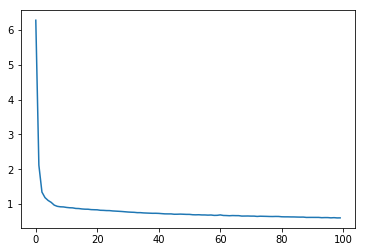

In [15]:
plot_loss_curve(Loss_History)

In [16]:
i = 5
j = 34

xi = X[i,:]
xj = X[j,:]
print("{}, {}".format(Y[i], Y[j]))
print("Original Distance {}".format(chi_square_distance(xi, xj)))
print("New Distance {}".format(chi_square_distance(L @ xi, L @ xj)))
print("Ratio {}".format(chi_square_distance(xi, xj) / chi_square_distance(L @ xi, L @ xj)))

Cherry 1, Mandarine
Original Distance 0.06513864547014236
New Distance 0.015239586635406496
Ratio 4.2743052701182975


Find what are the n (in this case n = 2) closest neighbors for a specific data point

In [14]:
for i in range(len(embeddings.T)):
    print(labels[i], knnClassifier.knn(embeddings.T[i], embeddings, labels))

Banana Lady Finger [('Banana Lady Finger', 0.0), ('Banana Lady Finger', 0.13373901)]
Banana Lady Finger [('Banana Lady Finger', 0.0), ('Cherry 1', 0.13212347)]
Banana Lady Finger [('Banana Lady Finger', 0.0), ('Cherry 1', 0.122355424)]
Banana Lady Finger [('Banana Lady Finger', 0.0), ('Cherry 1', 0.11165033)]
Banana Lady Finger [('Banana Lady Finger', 0.0), ('Avocado', 0.11710298)]
Cherry 1 [('Cherry 1', 0.0), ('Kiwi', 0.10999368)]
Cherry 1 [('Cherry 1', 0.0), ('Cherry 1', 0.1137767)]
Cherry 1 [('Cherry 1', 0.0), ('Avocado', 0.10714758)]
Cherry 1 [('Cherry 1', 0.0), ('Avocado', 0.11093686)]
Cherry 1 [('Cherry 1', 0.0), ('Avocado', 0.09377383)]
Avocado [('Avocado', 0.0), ('Avocado', 0.098978676)]
Avocado [('Avocado', 0.0), ('Cherry 1', 0.095110014)]
Avocado [('Avocado', 0.0), ('Cherry 1', 0.10213486)]
Avocado [('Avocado', 0.0), ('Kiwi', 0.100903355)]
Avocado [('Avocado', 0.0), ('Kiwi', 0.08227608)]
Kiwi [('Kiwi', 0.0), ('Avocado', 0.08789503)]
Kiwi [('Kiwi', 0.0), ('Kiwi', 0.067642055)]